# Analysis of human RAS saturation mutagenesis data

In this tutorial, we compare computational predictions from Rhapsody, PolyPhen-2 and EVmutation against experimental functional assessments of human RAS mutants presented in:
[Bandaru P et al, *Deconstruction of the Ras switching cycle through saturation mutagenesis*, Elife (2017)](https://elifesciences.org/articles/27810)

All results and figures presented here are described and interpreted in the Rhapsody paper and all data needed to fully reproduce them are provided.

In [1]:
import sys, os, pickle, csv, glob
import numpy as np
import prody as pd

In [2]:
# If needed, insert here local path to Rhapsody folder with the command:
# sys.path.insert(0, '/LOCAL_PATH/rhapsody/')
import rhapsody as rd

## Re-training of unbiased classifier

A few RAS mutations are found in the Integrated Dataset used for training. In order to get completely unbiased predictions, we will retrain a classifier by excluding those variants from the training dataset.

**NB:** The Uniprot name for gene HRAS is `P01112`.

In [3]:
# import the numpy structured array containing precomputed features 
# for the optimized training dataset
ID = np.load('../00-Training_Dataset/local/data/precomputed_features-ID_opt.npy')

ID_del = ID[ID['true_label'] == 1]  # deleterious SAVs
ID_neu = ID[ID['true_label'] == 0]  # neutral SAVs

known_del_SAVs = [SAV['SAV_coords'] for SAV in ID_del 
                  if SAV['SAV_coords'].startswith('P01112')]
known_neu_SAVs = [SAV['SAV_coords'] for SAV in ID_neu 
                  if SAV['SAV_coords'].startswith('P01112')]

print(f'{len(known_del_SAVs)} known deleterious RAS SAVs:')
print(known_del_SAVs)
print(f'\n{len(known_neu_SAVs)} known neutral RAS SAVs:')
print(known_neu_SAVs)

15 known deleterious RAS SAVs:
['P01112 117 K R', 'P01112 12 G A', 'P01112 12 G C', 'P01112 12 G D', 'P01112 12 G E', 'P01112 12 G S', 'P01112 12 G V', 'P01112 13 G C', 'P01112 13 G D', 'P01112 146 A V', 'P01112 22 Q K', 'P01112 58 T I', 'P01112 61 Q K', 'P01112 61 Q L', 'P01112 63 E K']

0 known neutral RAS SAVs:
[]


Let's exclude these variants from the dataset. 

In [4]:
ID_subset = ID[ [not SAV.startswith('P01112') for SAV in ID['SAV_coords']] ]
len(ID_subset)

20346

We use this subset of the Integrated Dataset to train unbiased versions of the Rhapsody classifiers:

In [5]:
if not os.path.isdir('local'):
    os.mkdir('local')

In [6]:
folder = 'local/results/'

if not os.path.isdir(folder):
    os.mkdir(folder)
    
    logfile = os.path.join(folder, 'RF_training.log')
    pd.LOGGER.start(logfile)
    
    for clsf_version in ['full', 'reduced']:
        # training of the Random Forest classifier on the given set of features
        featset = rd.DEFAULT_FEATSETS[clsf_version]
        sel = ['SAV_coords', 'true_label'] + featset
        rd.trainRFclassifier(ID_subset[sel])
        
        # store output files
        _folder = os.path.join(folder, clsf_version)
        os.mkdir(_folder)
        for file in glob.glob('*png') + ['trained_classifier.pkl',]:
            os.rename(file, os.path.join(_folder, file))
            
        pd.LOGGER.info('')

    pd.LOGGER.close(logfile)
else:
    print('Precomputed classifiers found.')

Precomputed classifiers found.


In [7]:
full_clsf = 'local/results/full/trained_classifier.pkl'
reduced_clsf = 'local/results/reduced/trained_classifier.pkl'

## Rhapsody predictions
We perform a complete scanning of all amino acid variants (*in silico* saturation mutagenesis) using the custom classifiers we just trained.

**NB:** PolyPhen-2 predictions are precomputed and saved in `data/pph2`

In [8]:
folder = 'local/results/predictions/'

if not os.path.isdir(folder):
    # run rhapsody
    rh = rd.rhapsody('data/pph2/pph2-full.txt', query_type='PolyPhen2',
                     main_classifier=full_clsf, aux_classifier=reduced_clsf)
    # store output files
    os.mkdir(folder)
    for f in glob.glob('rhapsody-*.*'):
        os.rename(f, os.path.join(folder, f))
else:
    with open(os.path.join(folder, 'rhapsody-pickle.pkl'), 'rb') as f:
        rh = pickle.load(f)
    print('Precomputed predictions imported.')

Precomputed predictions imported.


### Active *vs* inactive state
Rhapsody automatically maps most variants onto PDB structure `4Q21`, which is the GDP-complexed **inactive** conformation:

In [9]:
PDBIDs = list(rh.getPDBcoords()['PDBID'])
for PDBID in set(PDBIDs):
    print(f'{PDBID:4}  n.SAVs:  {PDBIDs.count(PDBID)}')

4Q21  n.SAVs:  3192
?     n.SAVs:  342
1AA9  n.SAVs:  57


We can force Rhapsody to use, for instance, the **active** (GTP-bound) structure `6Q21` instead:

In [10]:
folder = 'local/results/predictions_active/'

if not os.path.isdir(folder):
    # run rhapsody
    rh_active = rd.rhapsody('data/pph2/pph2-full.txt', query_type='PolyPhen2', 
                            main_classifier=full_clsf, aux_classifier=reduced_clsf,
                            custom_PDB='6Q21')
    # store output files
    os.mkdir(folder)
    for f in glob.glob('rhapsody-*.*'):
        os.rename(f, os.path.join(folder, f))
else:
    with open(os.path.join(folder, 'rhapsody-pickle.pkl'), 'rb') as f:
        rh_active = pickle.load(f)
    print('Precomputed predictions imported.')    

Precomputed predictions imported.


## Analysis of predictions: active *vs* inactive state

In [11]:
if not os.path.isdir('local/figures'):
    os.mkdir('local/figures')

In [12]:
import matplotlib.pyplot as plt
from scipy.stats.stats import spearmanr

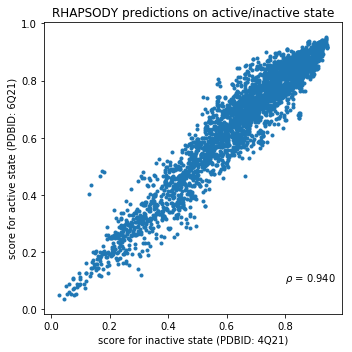

In [13]:
# import random forest scores
score_inactive = rh.getPredictions()['score']
score_active   = rh_active.getPredictions()['score']

fig, ax = plt.subplots(figsize=(5,5))

ax.scatter(score_inactive, score_active, marker='.')
ax.set_xlabel('score for inactive state (PDBID: 4Q21)')
ax.set_ylabel('score for active state (PDBID: 6Q21)')

# compute Spearman's correlation coefficient
sel = np.logical_and(~np.isnan(score_inactive), ~np.isnan(score_active))
rho = spearmanr(score_inactive[sel], score_active[sel])[0]

s = r'$\rho$'
ax.set_title('RHAPSODY predictions on active/inactive state')
ax.text(0.8, 0.1, f'{s} = {rho:5.3f}')

fig.tight_layout()
plt.savefig(f'local/figures/active_vs_inactive_correlation.png', dpi=300)

In general, predictions based on inactive *vs* active conformations are very similar. We can plot the *residue-averaged* prediction profiles on the respective structures to better highlight differences.

In [14]:
avg_prob = {}
avg_prob['inactive'] = rh.getResAvgPredictions()['path. prob.']
avg_prob['active'] = rh_active.getResAvgPredictions()['path. prob.']
avg_prob['difference'] = avg_prob['active'] - avg_prob['inactive']

# residue numbers
resids = rh.getResAvgPredictions()['PDB resid']

In [15]:
# import PDB structures
pdbs = {}
pdbs['inactive']   = pd.parsePDB('4q21', chain='A').select('protein and resid 2 to 166')
pdbs['active']     = pd.parsePDB('6q21', chain='A').select('protein and resid 2 to 166')
pdbs['difference'] = pdbs['active']

@> PDB file is found in the local folder (/home/lponzoni/.../4q21.pdb.gz).
@> 1447 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> PDB file is found in the local folder (/home/lponzoni/.../6q21.pdb.gz).
@> 1484 atoms and 1 coordinate set(s) were parsed in 0.03s.


In [16]:
for case in ['inactive', 'active', 'difference']:
    pdb = pdbs[case]
    # replace the B-factor column in chain A with predictions
    PDBresids = pdb.getResnums()
    new_betas = np.zeros_like(PDBresids, dtype=float)
    for resid, prob in zip(resids, avg_prob[case]):
        if np.isnan(prob):
            prob = 0
        new_betas[PDBresids==resid] = prob
    # write modified PDB
    pdb.setBetas(new_betas)
    f = pd.writePDB(f'local/figures/mapped_pdb-{case}', pdb)

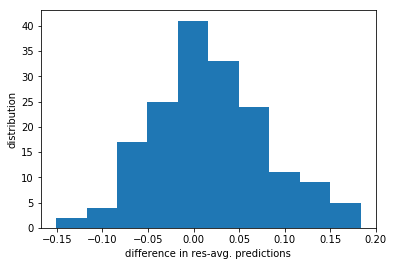

In [17]:
# plot the distribution of difference values
diff = avg_prob['difference']
plt.hist(diff[~np.isnan(diff)])
plt.ylabel('distribution')
plt.xlabel('difference in res-avg. predictions');

## Pathogenicity probability
The score returned by the random forest classifier is conveniently converted by Rhapsody in a "pathogencity probability", whose cutoff for classification lies at 0.5

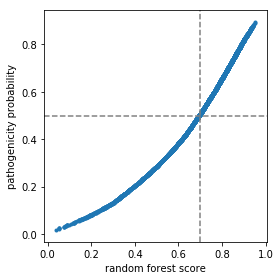

In [18]:
score = rh_active.getPredictions(classifier='main')['score']
pprob = rh_active.getPredictions(classifier='main')['path. prob.']
score_cutoff = rh_active.classifier['CV summary']['optimal cutoff']

fig, ax = plt.subplots(figsize=(4,4))

ax.scatter(score, pprob, marker='.')
ax.axvline(0.7, color='gray', ls='--')
ax.axhline(0.5, color='gray', ls='--')

ax.set_xlabel('random forest score')
ax.set_ylabel('pathogenicity probability')

fig.tight_layout()
plt.savefig(f'local/figures/score_vs_pprob.png', dpi=300)

## Comparison with experimental results from Bandaru et al.

In [19]:
# import data from file
data = {}

for f in glob.glob('data/*csv'):
    fname = os.path.basename(f, )
    case = fname.replace('.csv', '')
    with open(f, 'r') as _f:
        reader = csv.reader(_f)
        data[case] = list(reader)
        
exp_sequence = ''.join(data['attenuated_RAS'][1])

**NB:** The sequence used in the experiments is a substring of the Uniprot sequence:

In [20]:
acc = 'P01112'
sequence = pd.queryUniprot(acc)['sequence   0'].replace('\n', '')

In [21]:
print('Uniprot sequence length:', len(sequence))
print('Exp. sequence length:   ', len(exp_sequence))

Uniprot sequence length: 189
Exp. sequence length:    165


In [22]:
exp_sequence == sequence[1: len(exp_sequence)+1]

True

In [23]:
# convert data to dictionary
tables = {}

for case, d in data.items():
    resids = d[0][1:]
    wt_aas = d[1][1:]
    table = {}
    for line in d[2:]:
        mut_aa = line[0]
        for i, x in enumerate(line[1:]):
            resid = int(resids[i])
            wt_aa = wt_aas[i]
            table[f'P01112 {resid} {wt_aa} {mut_aa}'] = float(x)
    tables[case] = table

In [24]:
# the dictionary contains data from 4 different experimental setups
tables.keys()

dict_keys(['regulated_RAS', 'unregulated_RAS', 'attenuated_RAS', 'G12V_RAS'])

In [25]:
# put exp. data in array form and in the same order as Rhapsody predictions
SAV_coords = rh.getSAVcoords()

exp_scores = {}
for case, table in tables.items():
    a = np.zeros(len(SAV_coords))
    a[:] = np.nan
    for i, SAV in enumerate(SAV_coords):
        if SAV in table:
            a[i] = table[SAV]
    exp_scores[case] = a

# compute residue-averaged functional effects
avg_exp_scores = {}
for case, exp_score in exp_scores.items():
    avg_exp_scores[case] = np.nanmean(exp_score.reshape((-1, 19)), axis=1)

/home/lponzoni/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()


In [26]:
methods = ['Rhapsody (inactive state)', 
           'Rhapsody (active state)', 
           'EVmutation', 
           'PolyPhen-2']

# import computational scores
comput_scores = {
  'Rhapsody (inactive state)': rh.getPredictions()['path. prob.'], 
  'Rhapsody (active state)' :  rh_active.getPredictions()['path. prob.'], 
  'EVmutation' :               - rh.getPredictions()['EVmutation score'], 
  'PolyPhen-2' :               rh.getPredictions()['PolyPhen-2 score']
}

# import residue-averaged computational scores
avg_comput_scores = {
  'Rhapsody (inactive state)': rh.getResAvgPredictions()['path. prob.'], 
  'Rhapsody (active state)' :  rh_active.getResAvgPredictions()['path. prob.'], 
  'EVmutation' :               - rh.getResAvgPredictions()['EVmutation score'], 
  'PolyPhen-2' :               rh.getResAvgPredictions()['PolyPhen-2 score']
}

### Spearman correlation

In the following, we compute and plot the correlation between experimental measurements and computational predictions.

In [27]:
exp_comp_methods = ['regulated_RAS'] + methods

print(' '*18, end='')
for m in exp_comp_methods:
    m = m.replace('inactive state', 'in.')
    m = m.replace('active state', 'act.')
    print(f'{m:18}', end='')
print()
for i, m_i in enumerate(exp_comp_methods):
    m = m_i.replace('inactive state', 'in.')
    m = m.replace('active state', 'act.')
    print(f'{m:18} ', end='')
    if i == 0:
        s_i = exp_scores[m_i]
        a_i = avg_exp_scores[m_i]
    else:
        s_i = comput_scores[m_i]
        a_i = avg_comput_scores[m_i]
    for j, m_j in enumerate(exp_comp_methods):
        if j == 0:
            s_j = exp_scores[m_j]
            a_j = avg_exp_scores[m_j]
        else:
            s_j = comput_scores[m_j]
            a_j = avg_comput_scores[m_j]
        # compute Spearman's correlation
        if j > i:
            sel = np.logical_and(~np.isnan(s_i), ~np.isnan(s_j))
            rho = spearmanr(s_i[sel], s_j[sel])[0]
            s = f'{rho:5.3f}'
        elif j < i:
            sel = np.logical_and(~np.isnan(a_i), ~np.isnan(a_j))
            rho = spearmanr(a_i[sel], a_j[sel])[0]
            s = f'({rho:5.3f})'
        else:
            s = '-'
        print(f'{s:<18}', end='')
    print()

                  regulated_RAS     Rhapsody (in.)    Rhapsody (act.)   EVmutation        PolyPhen-2        
regulated_RAS      -                 -0.426            -0.428            -0.420            -0.364            
Rhapsody (in.)     (-0.603)          -                 0.939             0.715             0.820             
Rhapsody (act.)    (-0.570)          (0.939)           -                 0.716             0.812             
EVmutation         (-0.518)          (0.811)           (0.788)           -                 0.703             
PolyPhen-2         (-0.513)          (0.874)           (0.862)           (0.784)           -                 


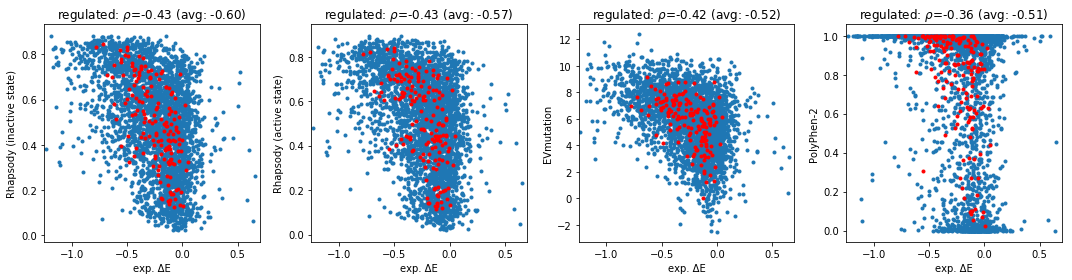

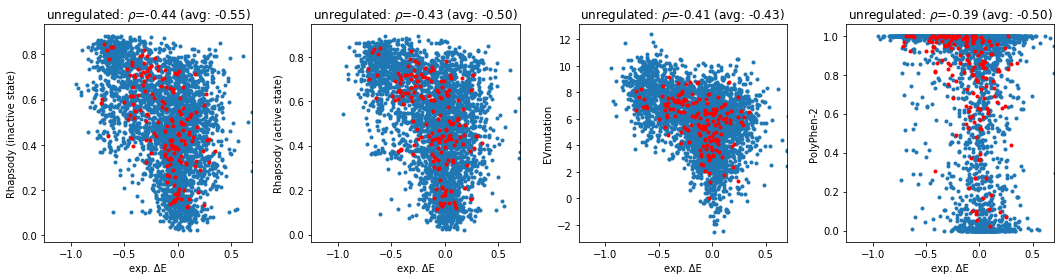

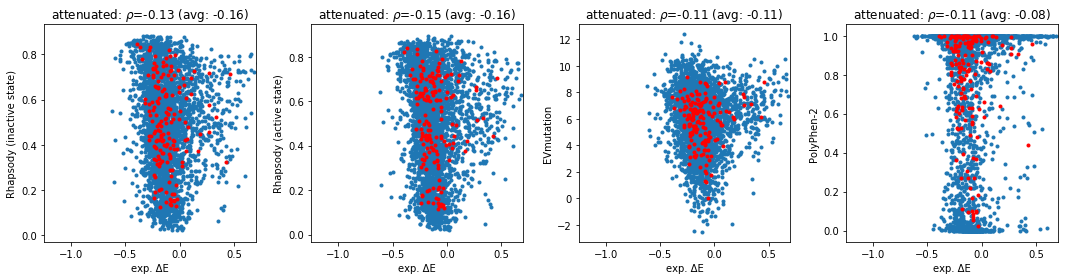

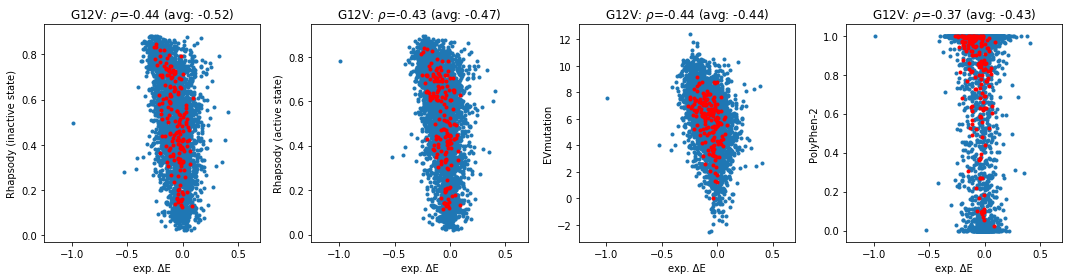

In [28]:
for case in exp_scores:
    exp_score     = exp_scores[case]
    avg_exp_score = avg_exp_scores[case]
    
    fig, axes = plt.subplots(1, 4, figsize=(15,4))
    
    for i, ax in enumerate(axes):
        method = methods[i]
        # individual fitness scores
        cs = comput_scores[method]
        ax.scatter(exp_score, cs, marker='.')
        sel = np.logical_and(~np.isnan(exp_score), ~np.isnan(cs))
        rho = spearmanr(exp_score[sel], cs[sel])[0]
        # residue-averaged fitness scores
        acs = avg_comput_scores[method]
        ax.scatter(avg_exp_score, acs, marker='.', c='r')
        sel = np.logical_and(~np.isnan(avg_exp_score), ~np.isnan(acs))
        rho_av = spearmanr(avg_exp_score[sel], acs[sel])[0]
        # print labels
        ax.set_ylabel(method)
        s = r'$\rho$'
        ax.set_title(f'{case[:-4]}: {s}={rho:5.2f} (avg: {rho_av:5.2f})')
        ax.set_xlim((-1.25, 0.7))
        ax.set_xlabel('exp. ΔE')

    fig.tight_layout()
    plt.savefig(f'local/figures/correlation-{case}.png', dpi=300)

Since the goal of Rhapsody is to identify mutations that impair the normal activity and interactions of proteins, specifically by taking into account changes to their internal structural dynamics, we can focus on the "regulated" case (its "wild-type" context) among those presented in the paper.
From the plots in the first line, we see that Rhapsody (computed on both inactive and active states) performs in general better than both EVmutation and PolyPhen-2. 

### ROCs, Precision-Recall curves and other metrics

We can also obtain a binary classification from the distribution of functional effects by setting a cutoff according to what is considered a "significant loss of function". We will choose the median as cutoff. This allows us to compute ROC and Precision-Recall curves and compare performances based on different metrics.

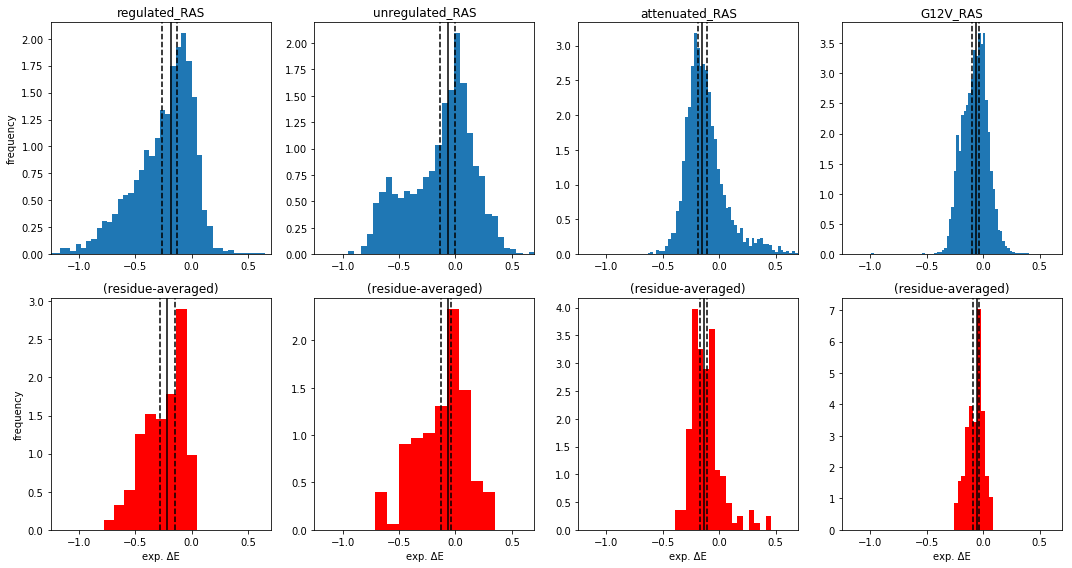

In [29]:
cutoff_qs = [40, 50, 60]
cutoff_qs.sort()

cutoffs = {}
avg_cutoffs = {}

fig, axes = plt.subplots(2, 4, figsize=(15,8))

for i, case in enumerate(exp_scores):
    exp_score = exp_scores[case]
    exp_score = exp_score[~np.isnan(exp_score)]
    avg_exp_score = avg_exp_scores[case]
    avg_exp_score = avg_exp_score[~np.isnan(avg_exp_score)]
    
    # cutoff definitions
    cutoffs[case]     = {q: np.nanpercentile(exp_score, q) for q in cutoff_qs}
    avg_cutoffs[case] = {q: np.nanpercentile(avg_exp_score, q) for q in cutoff_qs}
    
    ax1 = axes[0, i]
    ax2 = axes[1, i]
    
    ax1.hist(exp_score, density=True, bins='auto')
    ax2.hist(avg_exp_score, density=True, bins='auto', color='red')
    for q in cutoff_qs:
        cutoff     = cutoffs[case][q]
        avg_cutoff = avg_cutoffs[case][q]
        if q == cutoff_qs[1]:
            ax1.axvline(cutoff, color='k') 
            ax2.axvline(avg_cutoff, color='k') 
        else:
            ax1.axvline(cutoff, color='k', ls='--') 
            ax2.axvline(avg_cutoff, color='k', ls='--') 
    
    ax1.set_title(case)
    ax2.set_title('(residue-averaged)')
    ax1.set_xlim((-1.25, 0.7))
    ax2.set_xlim((-1.25, 0.7))
    ax2.set_xlabel('exp. ΔE')
    
axes[0,0].set_ylabel('frequency')
axes[1,0].set_ylabel('frequency')
    
fig.tight_layout()
fig.savefig(f'local/figures/histograms-cutoff.png', dpi=300)

In [30]:
cutoffs

{'regulated_RAS': {40: -0.2627257429396158,
  50: -0.185003117052718,
  60: -0.12880622092509258},
 'unregulated_RAS': {40: -0.1391366833582583,
  50: -0.064531249718215,
  60: -0.003961961465336603},
 'attenuated_RAS': {40: -0.18497620448400998,
  50: -0.149177777500935,
  60: -0.11280964083570642},
 'G12V_RAS': {40: -0.09607740790955578,
  50: -0.065299663607474,
  60: -0.03632001506460561}}

In [31]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import f1_score, matthews_corrcoef

metrics = {}

for case in exp_scores:
    
    metrics[case] = {}
    
    # experimental measurements (fitness effects)
    exp_score     = exp_scores[case]
    avg_exp_score = avg_exp_scores[case]

    # loop over computational methods 
    for method in methods:
                      
        # individual and residue-averaged computational predictions fitness effects
        comput_score = comput_scores[method]
        avg_comput_score = avg_comput_scores[method]
        
        # discard NaN values
        sel = np.logical_and(~np.isnan(exp_score), ~np.isnan(comput_score))
        avg_sel = np.logical_and(~np.isnan(avg_exp_score), ~np.isnan(avg_comput_score))

        m = {}
        
        # loop over cutoffs for experimental values
        for q in cutoff_qs:
            cutoff     = cutoffs[case][q]
            avg_cutoff = avg_cutoffs[case][q]
            
            m[q] = {}
            
            # binary classification and computational score for individual measurements
            exp_class = np.where(exp_score[sel] < cutoff, 1, 0)
            cs = comput_score[sel]
            # curves and metrics
            fpr, tpr, _   = roc_curve(exp_class, cs)
            prc, rec, _   = precision_recall_curve(exp_class, cs)
            m[q]['ROC']   = (fpr, tpr)
            m[q]['PRC']   = (rec, prc)
            m[q]['AUROC'] = roc_auc_score(exp_class, cs)
            m[q]['AUPRC'] = average_precision_score(exp_class, cs)

            # binary classification for residue-averaged measurements
            exp_class = np.where(avg_exp_score[avg_sel] < avg_cutoff, 1, 0)
            cs = avg_comput_score[avg_sel]
            # curves and metrics
            fpr, tpr, _   = roc_curve(exp_class, cs)
            prc, rec, _   = precision_recall_curve(exp_class, cs)
            m[q]['avg_ROC']   = (fpr, tpr)
            m[q]['avg_PRC']   = (rec, prc)
            m[q]['avg_AUROC'] = roc_auc_score(exp_class, cs)
            m[q]['avg_AUPRC'] = average_precision_score(exp_class, cs)

        metrics[case][method] = m

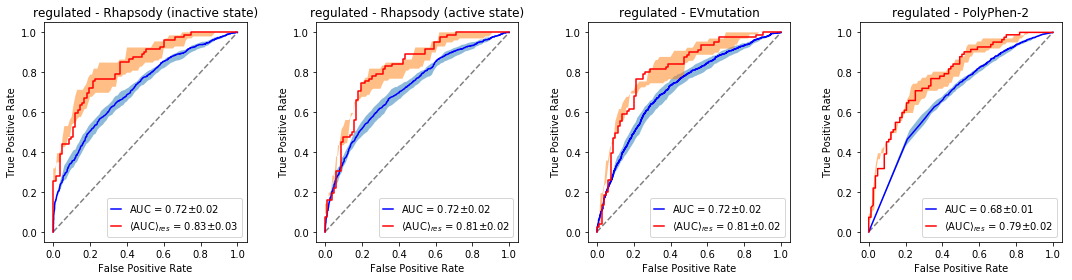

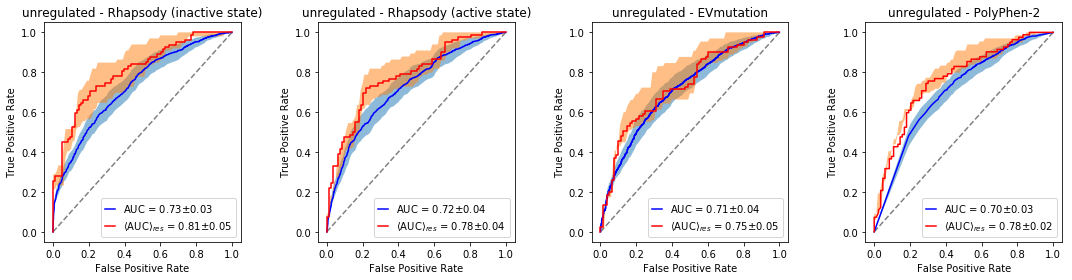

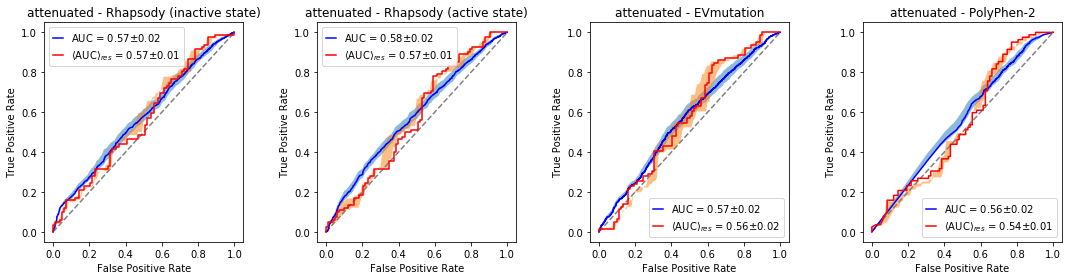

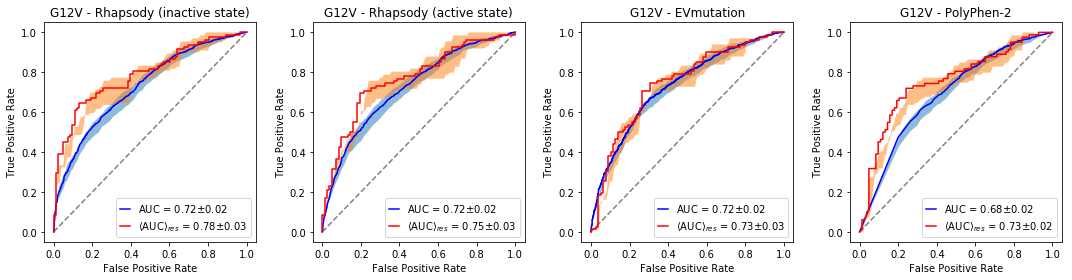

In [32]:
for case in exp_scores:

    fig, axes = plt.subplots(1, 4, figsize=(15,4))
    
    for i, ax in enumerate(axes):
        method = methods[i]
        
        m = metrics[case][method]
        q0, q1, q2 = cutoff_qs
        
        # random ROC
        ax.plot([0,1], [0,1], '--', color='gray')
        
        # plot for individual fitness effects
        aucs = [m[q]['AUROC'] for q in m.keys()]
        l = r'AUC = {:4.2f}$\pm${:4.2f}'.format(np.mean(aucs), np.std(aucs))
        ax.plot(m[q1]['ROC'][0], m[q1]['ROC'][1], 'b-', label=l)
        x_dense = np.arange(0,1,.01) 
        ax.fill_between(x_dense, np.interp(x_dense, m[q0]['ROC'][0], m[q0]['ROC'][1]), 
                                 np.interp(x_dense, m[q2]['ROC'][0], m[q2]['ROC'][1]), alpha=.5)

        # plot for residue-averaged fitness effects
        aucs = [m[q]['avg_AUROC'] for q in m.keys()]
        l = r'$\langle$AUC$\rangle _{res}$ = ' 
        l += r'{:4.2f}$\pm${:4.2f}'.format(np.mean(aucs), np.std(aucs)) 
        ax.plot(m[q1]['avg_ROC'][0], m[q1]['avg_ROC'][1], 'r-', label=l)
        x_dense = np.arange(0,1,.01) 
        ax.fill_between(x_dense, np.interp(x_dense, m[q0]['avg_ROC'][0], m[q0]['avg_ROC'][1]), 
                                 np.interp(x_dense, m[q2]['avg_ROC'][0], m[q2]['avg_ROC'][1]), alpha=.5)
        
        # set labels
        ax.set_title(f'{case[:-4]} - {method}')   
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.legend(handlelength=1)

    fig.tight_layout()
    fig.savefig(f'local/figures/ROC-{case}.png', dpi=300)

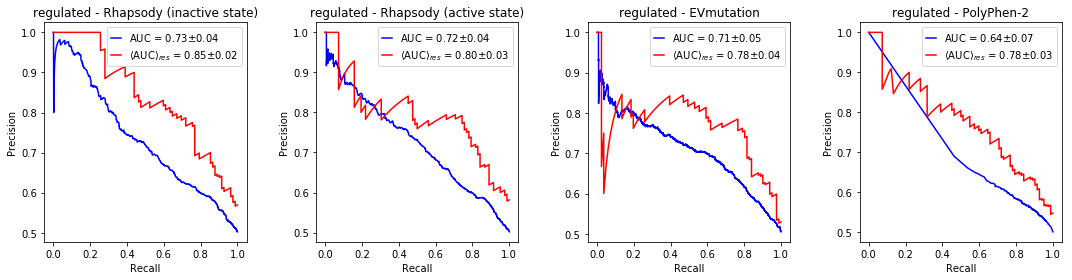

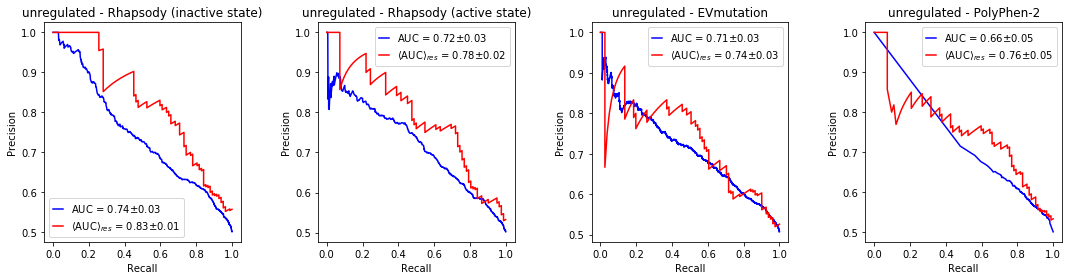

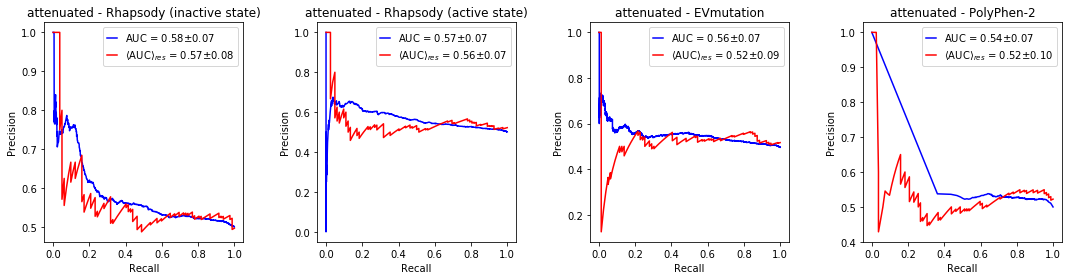

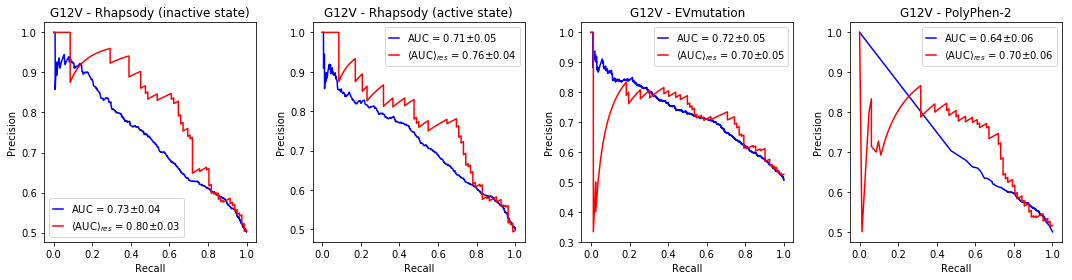

In [33]:
for case in exp_scores:

    fig, axes = plt.subplots(1, 4, figsize=(15,4))
    
    for i, ax in enumerate(axes):
        method = methods[i]
        
        m = metrics[case][method]
        q0, q1, q2 = cutoff_qs
        
        # plot for individual fitness effects
        aucs = [m[q]['AUPRC'] for q in cutoff_qs]
        l = r'AUC = {:4.2f}$\pm${:4.2f}'.format(np.mean(aucs), np.std(aucs))
        ax.plot(m[q1]['PRC'][0], m[q1]['PRC'][1], 'b-', label=l)

        # plot for residue-averaged fitness effects
        aucs = [m[q]['avg_AUPRC'] for q in cutoff_qs]
        l = r'$\langle$AUC$\rangle _{res}$ = ' 
        l += r'{:4.2f}$\pm${:4.2f}'.format(np.mean(aucs), np.std(aucs)) 
        ax.plot(m[q1]['avg_PRC'][0], m[q1]['avg_PRC'][1], 'r-', label=l)
        
        # set labels
        ax.set_title(f'{case[:-4]} - {method}')   
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        ax.legend(handlelength=1)

    fig.tight_layout()
    fig.savefig(f'local/figures/PRC-{case}.png', dpi=300)

In the following, we apply an alternative definition of "deleterious" variants, that include not only loss-of-function mutations, but also gain-of-function mutations. We can do that by considering as "positive cases" those whose difference in fitness with respect to wild-type is greater than a certain threshold, in both directions.

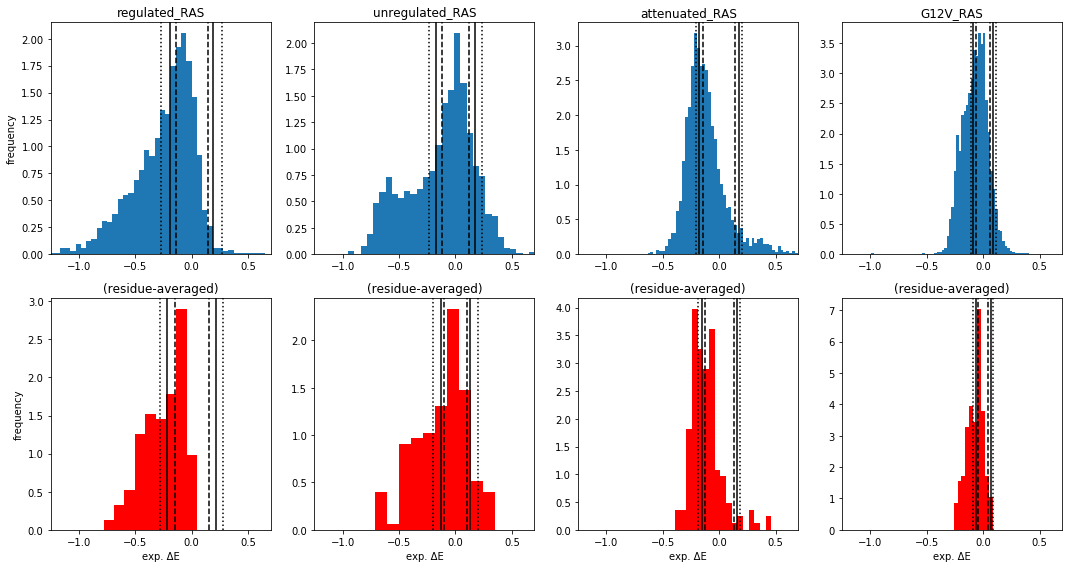

In [34]:
threshold_qs = [40, 50, 60]
threshold_qs.sort()

thresholds = {}
avg_thresholds = {}


fig, axes = plt.subplots(2, 4, figsize=(15,8))

for i, case in enumerate(exp_scores):
    exp_score = exp_scores[case]
    exp_score = exp_score[~np.isnan(exp_score)]
    avg_exp_score = avg_exp_scores[case]
    avg_exp_score = avg_exp_score[~np.isnan(avg_exp_score)]
    
    # threshold definitions
    thresholds[case]     = {q: np.nanpercentile(abs(exp_score), q) for q in cutoff_qs}
    avg_thresholds[case] = {q: np.nanpercentile(abs(avg_exp_score), q) for q in cutoff_qs}
    
    ax1 = axes[0, i]
    ax2 = axes[1, i]
    
    ax1.hist(exp_score, density=True, bins='auto')
    ax2.hist(avg_exp_score, density=True, bins='auto', color='red')

    for q, ls in zip(threshold_qs, ['--', '-', ':']):
        threshold     = thresholds[case][q]
        avg_threshold = avg_thresholds[case][q]
        ax1.axvline( threshold, color='k', ls=ls) 
        ax1.axvline(-threshold, color='k', ls=ls) 
        ax2.axvline( avg_threshold, color='k', ls=ls) 
        ax2.axvline(-avg_threshold, color='k', ls=ls) 
    
    ax1.set_title(case)
    ax2.set_title('(residue-averaged)')
    ax1.set_xlim((-1.25, 0.7))
    ax2.set_xlim((-1.25, 0.7))
    ax2.set_xlabel('exp. ΔE')
    
axes[0,0].set_ylabel('frequency')
axes[1,0].set_ylabel('frequency')

fig.tight_layout()
fig.savefig(f'local/figures/histograms-threshold.png', dpi=300)

In [35]:
thresholds

{'regulated_RAS': {40: 0.14224669024212144,
  50: 0.1932642529612,
  60: 0.2684421666548036},
 'unregulated_RAS': {40: 0.12258084873149042,
  50: 0.170601543523011,
  60: 0.23386959130022078},
 'attenuated_RAS': {40: 0.142329784270181,
  50: 0.17526896277679,
  60: 0.2046635357484472},
 'G12V_RAS': {40: 0.06454427247713701,
  50: 0.085167183460886,
  60: 0.11040889530293377}}

In [36]:
metrics_2 = {}

for case in exp_scores:
    
    metrics_2[case] = {}
    
    # experimental measurements (fitness effects)
    exp_score     = exp_scores[case]
    avg_exp_score = avg_exp_scores[case]

    # loop over computational methods 
    for method in methods:
                      
        # individual and residue-averaged computational predictions fitness effects
        comput_score = comput_scores[method]
        avg_comput_score = avg_comput_scores[method]
        
        # discard NaN values
        sel = np.logical_and(~np.isnan(exp_score), ~np.isnan(comput_score))
        avg_sel = np.logical_and(~np.isnan(avg_exp_score), ~np.isnan(avg_comput_score))

        m = {}
        
        # loop over thresholds for experimental values
        for q in threshold_qs:
            threshold     = thresholds[case][q]
            avg_threshold = avg_thresholds[case][q]
            
            m[q] = {}
            
            # binary classification and computational score for individual measurements
            exp_class = np.where(abs(exp_score[sel]) > threshold, 1, 0)
            cs = comput_score[sel]
            # curves and metrics
            fpr, tpr, _   = roc_curve(exp_class, cs)
            prc, rec, _   = precision_recall_curve(exp_class, cs)
            m[q]['ROC']   = (fpr, tpr)
            m[q]['PRC']   = (rec, prc)
            m[q]['AUROC'] = roc_auc_score(exp_class, cs)
            m[q]['AUPRC'] = average_precision_score(exp_class, cs)


            # binary classification for residue-averaged measurements
            exp_class = np.where(abs(avg_exp_score[avg_sel]) > avg_threshold, 1, 0)
            cs = avg_comput_score[avg_sel]
            # curves and metrics
            fpr, tpr, _   = roc_curve(exp_class, cs)
            prc, rec, _   = precision_recall_curve(exp_class, cs)
            m[q]['avg_ROC']   = (fpr, tpr)
            m[q]['avg_PRC']   = (rec, prc)
            m[q]['avg_AUROC'] = roc_auc_score(exp_class, cs)
            m[q]['avg_AUPRC'] = average_precision_score(exp_class, cs)

        metrics_2[case][method] = m

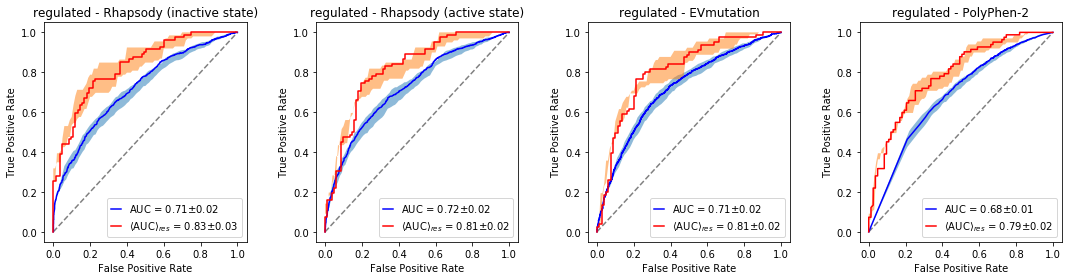

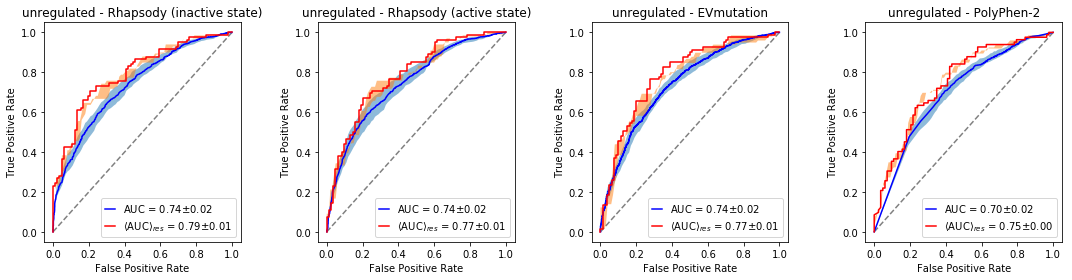

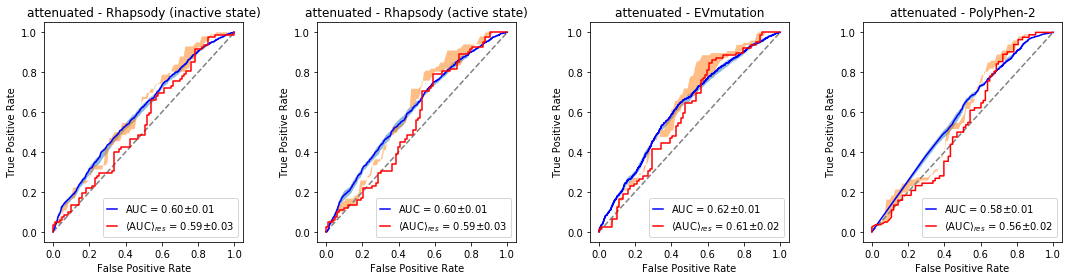

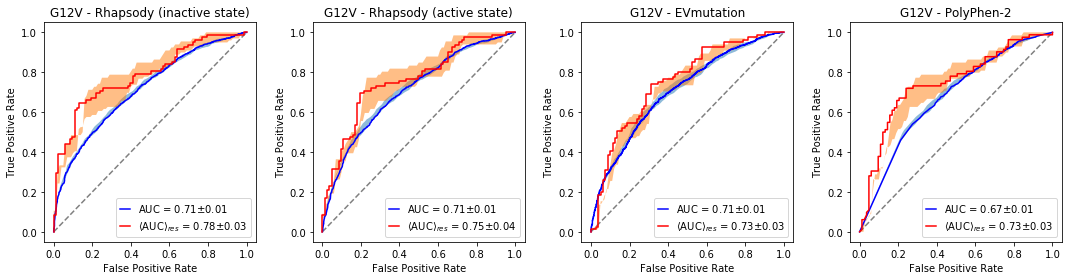

In [37]:
for case in exp_scores:

    fig, axes = plt.subplots(1, 4, figsize=(15,4))
    
    for i, ax in enumerate(axes):
        method = methods[i]
        
        m = metrics_2[case][method]
        q0, q1, q2 = threshold_qs
        
        # random ROC
        ax.plot([0,1], [0,1], '--', color='gray')
        
        # plot for individual fitness effects
        aucs = [m[q]['AUROC'] for q in m.keys()]
        l = r'AUC = {:4.2f}$\pm${:4.2f}'.format(np.mean(aucs), np.std(aucs))
        ax.plot(m[q1]['ROC'][0], m[q1]['ROC'][1], 'b-', label=l)
        x_dense = np.arange(0,1,.01) 
        ax.fill_between(x_dense, np.interp(x_dense, m[q0]['ROC'][0], m[q0]['ROC'][1]), 
                                 np.interp(x_dense, m[q2]['ROC'][0], m[q2]['ROC'][1]), alpha=.5)

        # plot for residue-averaged fitness effects
        aucs = [m[q]['avg_AUROC'] for q in m.keys()]
        l = r'$\langle$AUC$\rangle _{res}$ = ' 
        l += r'{:4.2f}$\pm${:4.2f}'.format(np.mean(aucs), np.std(aucs)) 
        ax.plot(m[q1]['avg_ROC'][0], m[q1]['avg_ROC'][1], 'r-', label=l)
        x_dense = np.arange(0,1,.01) 
        ax.fill_between(x_dense, np.interp(x_dense, m[q0]['avg_ROC'][0], m[q0]['avg_ROC'][1]), 
                                 np.interp(x_dense, m[q2]['avg_ROC'][0], m[q2]['avg_ROC'][1]), alpha=.5)
        
        # set labels
        ax.set_title(f'{case[:-4]} - {method}')   
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.legend(handlelength=1)

    fig.tight_layout()
    fig.savefig(f'local/figures/ROC-2-{case}.png', dpi=300)

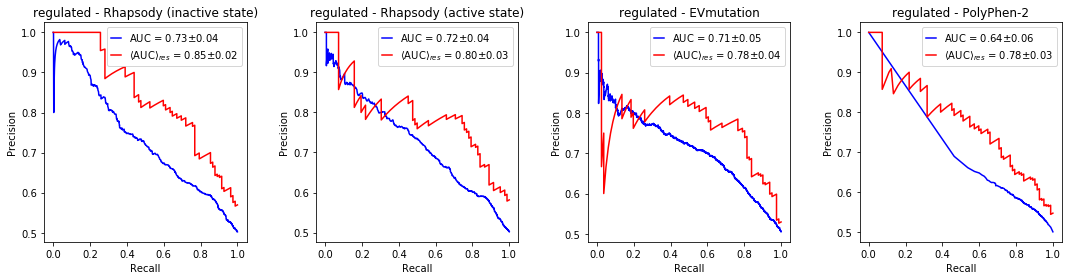

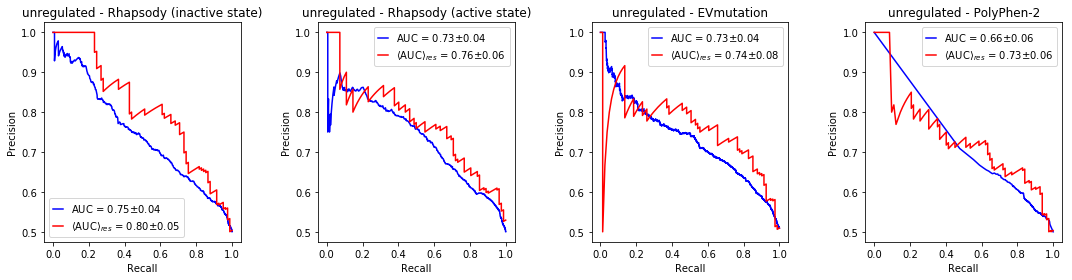

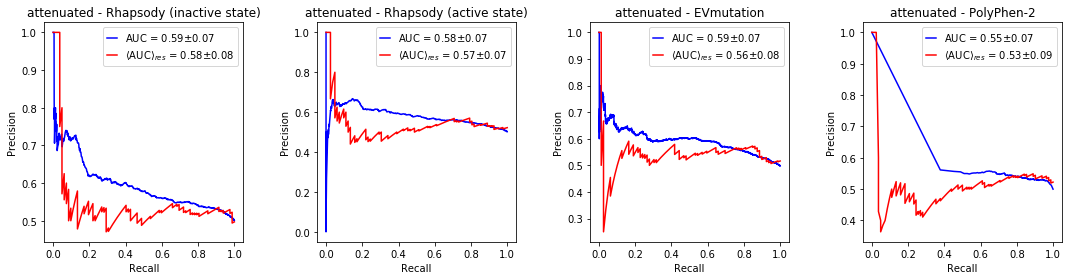

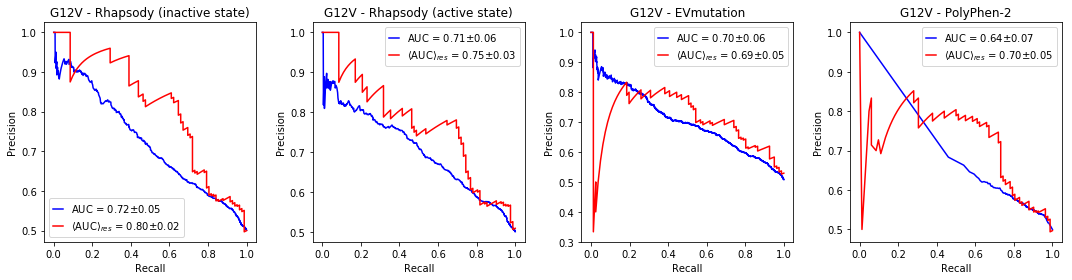

In [38]:
for case in exp_scores:

    fig, axes = plt.subplots(1, 4, figsize=(15,4))
    
    for i, ax in enumerate(axes):
        method = methods[i]
        
        m = metrics_2[case][method]
        q0, q1, q2 = threshold_qs
        
        # plot for individual fitness effects
        aucs = [m[q]['AUPRC'] for q in cutoff_qs]
        l = r'AUC = {:4.2f}$\pm${:4.2f}'.format(np.mean(aucs), np.std(aucs))
        ax.plot(m[q1]['PRC'][0], m[q1]['PRC'][1], 'b-', label=l)

        # plot for residue-averaged fitness effects
        aucs = [m[q]['avg_AUPRC'] for q in cutoff_qs]
        l = r'$\langle$AUC$\rangle _{res}$ = ' 
        l += r'{:4.2f}$\pm${:4.2f}'.format(np.mean(aucs), np.std(aucs)) 
        ax.plot(m[q1]['avg_PRC'][0], m[q1]['avg_PRC'][1], 'r-', label=l)
        
        # set labels
        ax.set_title(f'{case[:-4]} - {method}')   
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        ax.legend(handlelength=1)

    fig.tight_layout()
    fig.savefig(f'local/figures/PRC-2-{case}.png', dpi=300)

### *In silico* saturation mutagenesis table
Experimental measurements (fitness scores) are reversed to make the comparison with computational profiles easier.

In [39]:
exp_score = - exp_scores['regulated_RAS']

In [40]:
rd.print_sat_mutagen_figure('local/figures/sat_mutagen-inactive-1', rh, 
                            extra_plot=exp_score, res_interval=(1,95))
rd.print_sat_mutagen_figure('local/figures/sat_mutagen-inactive-2', rh, 
                            extra_plot=exp_score, res_interval=(95,190))

@> Saturation mutagenesis figure saved to local/figures/sat_mutagen-inactive-1.png
@> Saturation mutagenesis figure saved to local/figures/sat_mutagen-inactive-2.png


In [41]:
rd.print_sat_mutagen_figure('local/figures/sat_mutagen-active-1', rh_active, 
                            extra_plot=exp_score, res_interval=(1,95))
rd.print_sat_mutagen_figure('local/figures/sat_mutagen-active-2', rh_active, 
                            extra_plot=exp_score, res_interval=(95,190))

@> Saturation mutagenesis figure saved to local/figures/sat_mutagen-active-1.png
@> Saturation mutagenesis figure saved to local/figures/sat_mutagen-active-2.png


We plot the secondary structure and solvent accessible surface area (SASA) in two strips to be paired with the saturation mutagenesis tables.

In [42]:
# compute secondary structure and SASA with DSSP
ag = pd.performDSSP('6q21')
os.remove('6q21.pdb')
os.remove('6q21.dssp')

@> PDB file is found in the local folder (6q21.pdb).
@> 6057 atoms and 1 coordinate set(s) were parsed in 0.08s.


In [43]:
SASAs = np.zeros(190)
SSTRs = np.zeros(190)
SASAs[:] = np.nan
SSTRs[:] = np.nan

ag_ca = ag['A'].ca
for resid, sasa, sstr in zip(ag_ca.getResnums(), 
                             ag_ca.getData('dssp_acc'), 
                             ag_ca.getSecstrs()):
    SASAs[resid-1] = sasa
    if sstr in list('GHI'): # helix
        _sstr = 2
    elif sstr in list('EB'): # strand
        _sstr = 1
    else: # loop
        _sstr = np.nan
    SSTRs[resid-1] = _sstr

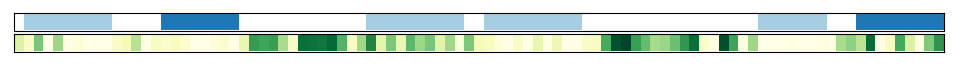

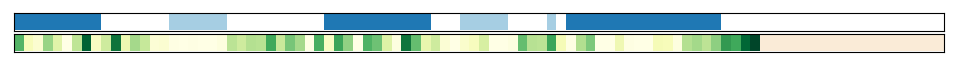

In [44]:
for i, (res_i, res_f) in enumerate([(1,95), (95,190)]):
    
    fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(12, 0.5))
    for ax in (ax0, ax1):
        ax.tick_params(axis='both', which='both', left=False, bottom=False, 
                       labelbottom=False, labelleft=False)
    # plot secondary structure
    SSTR_plot = SSTRs[res_i-1:res_f].reshape((1,-1))
    ax0.imshow(SSTR_plot, aspect='auto', cmap='Paired', vmax=12)
    # plot SASA
    SASA_plot = SASAs[res_i-1:res_f].reshape((1,-1))
    ax1.imshow(SASA_plot, aspect='auto', cmap='YlGn')
    fig.savefig(f'local/figures/sat_mutagen-active-{i+1}-strip', dip=300)

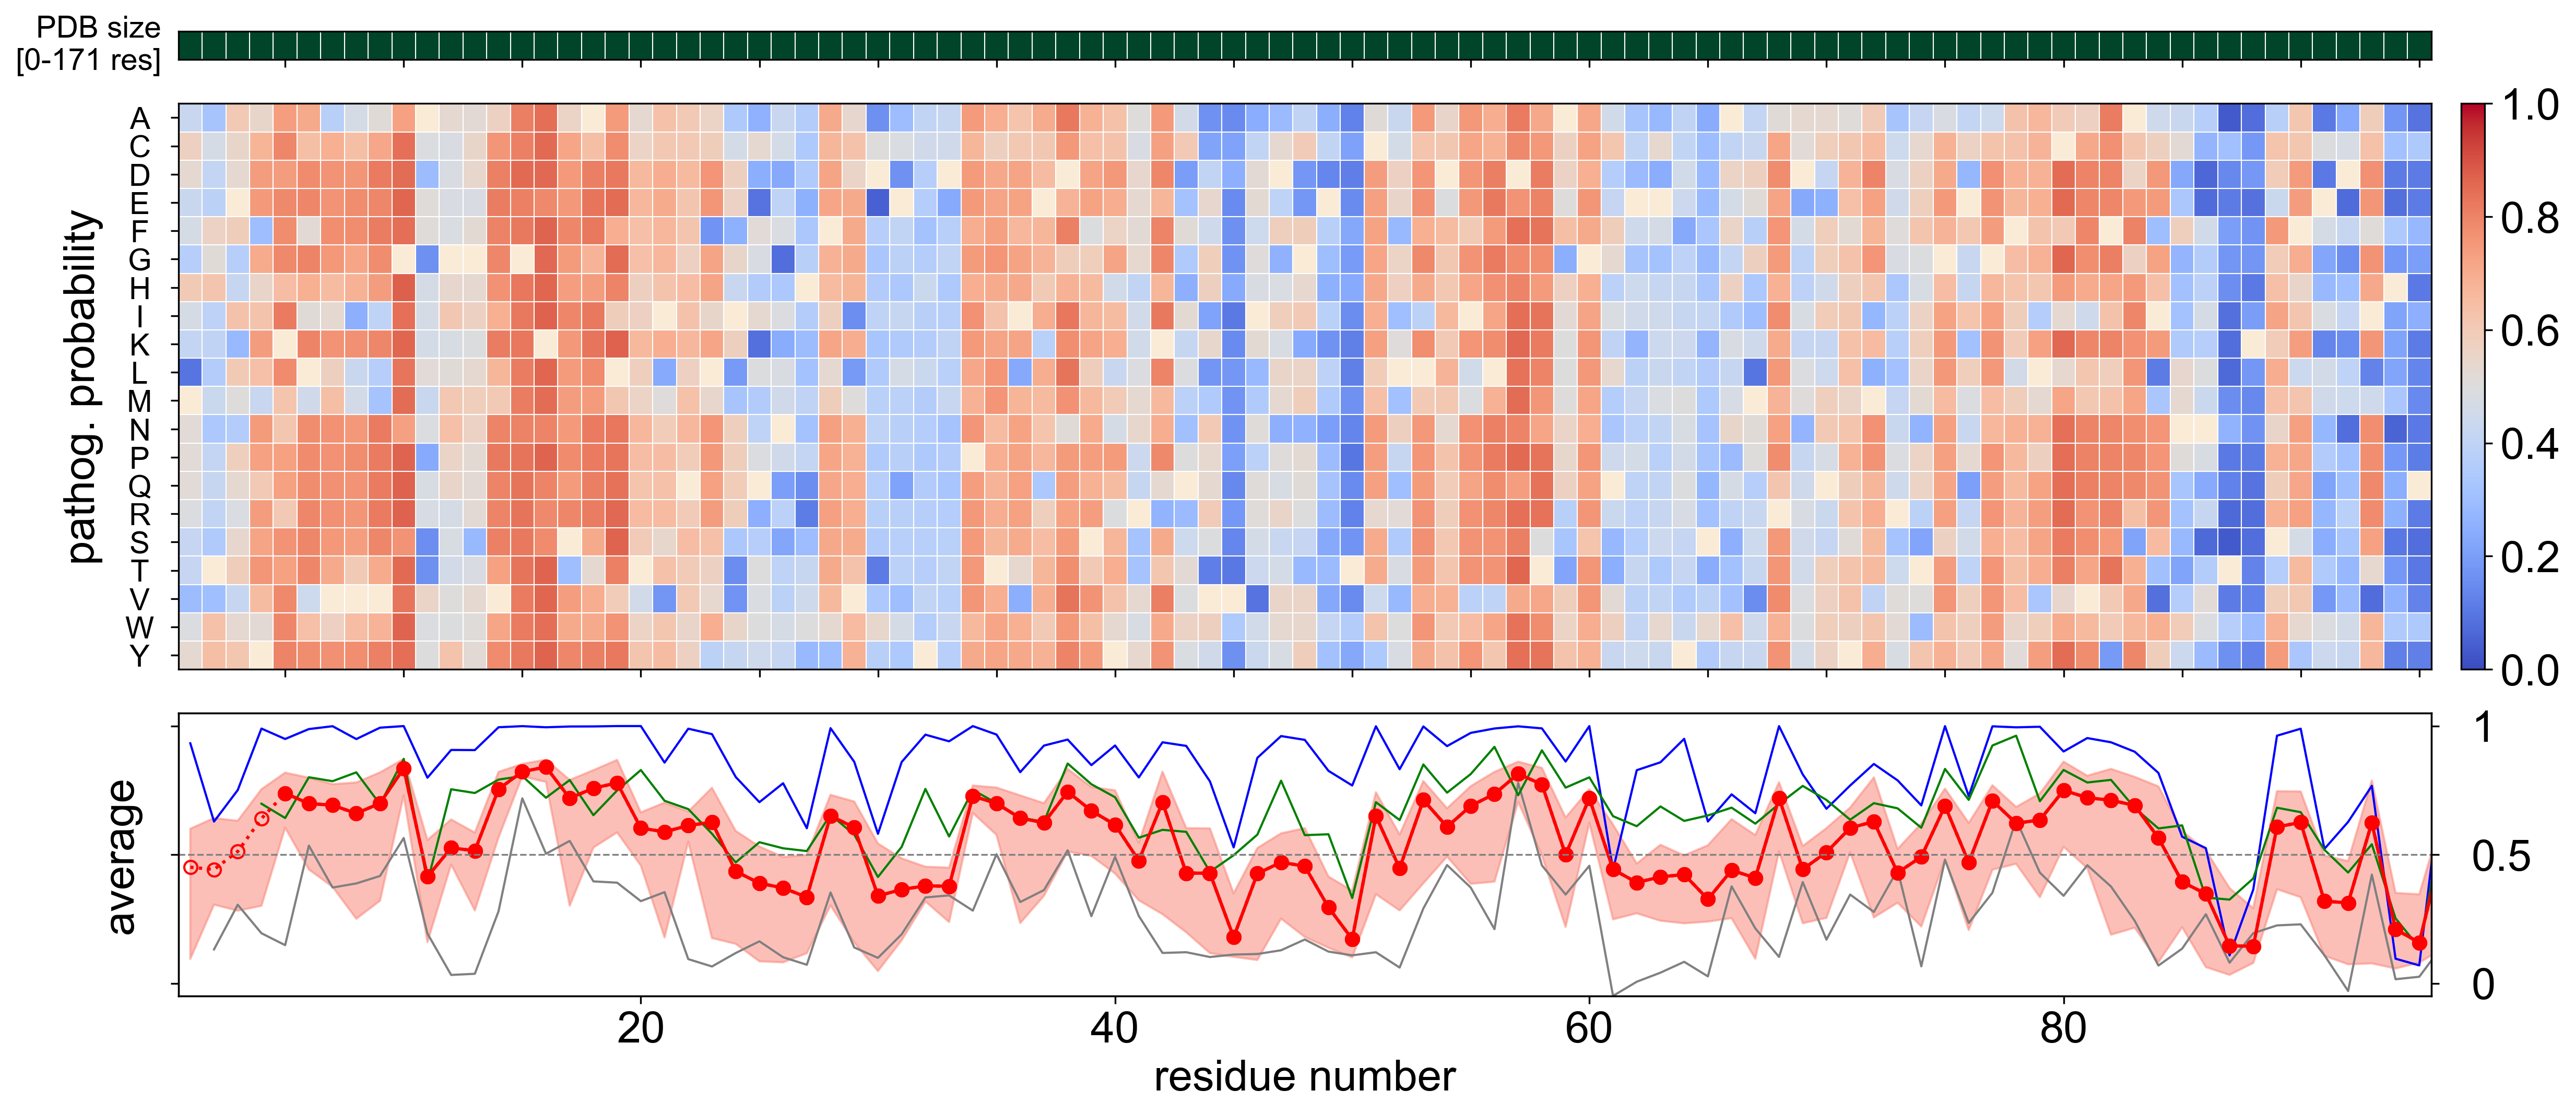

In [45]:
# example of saturation mutagenesis table 
from IPython.display import Image
Image('local/figures/sat_mutagen-active-1.png')

### Agreement with experimental measurements shown on PDB structure
We highlight on the 3D structure of RAS those residues were Rhapsody generally fails to provide correct predictions, in an attempt to identify the method's limitations.

/home/lponzoni/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys
/home/lponzoni/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less
  
/home/lponzoni/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()
/home/lponzoni/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less
  if sys.path[0] == '':


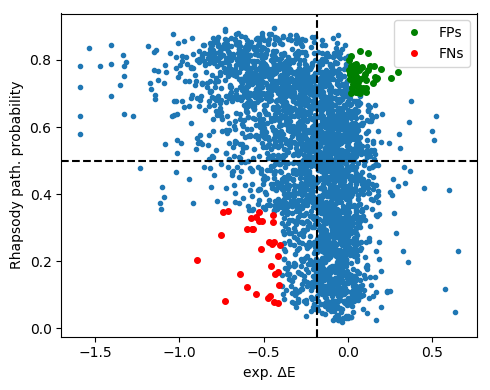

In [46]:
exp_score = exp_scores['regulated_RAS']
comput_score = rh_active.getPredictions()['path. prob.']

exp_cutoff    = np.nanmedian(exp_score)
comput_cutoff = 0.5

FPs = np.logical_and(exp_score > exp_cutoff, comput_score > comput_cutoff)
FNs = np.logical_and(exp_score < exp_cutoff, comput_score < comput_cutoff)

# We arbitrarily select two subsets with the least accurate predictions
worst_FPs = np.logical_and(exp_score > 0, comput_score > 0.7)
worst_FNs = np.logical_and(exp_score < -.4, comput_score < 0.35)

fig, ax = plt.subplots(figsize=(5,4))
ax.plot(exp_score, comput_score, '.')
ax.plot(exp_score[worst_FPs], comput_score[worst_FPs], 'g.', ms=8, label='FPs')
ax.plot(exp_score[worst_FNs], comput_score[worst_FNs], 'r.', ms=8, label='FNs')

ax.axvline(exp_cutoff, ls='--', c='k')
ax.axhline(comput_cutoff, ls='--', c='k')

ax.set_ylabel('Rhapsody path. probability')
ax.set_xlabel('exp. ΔE')

ax.legend()
fig.tight_layout()
plt.savefig(f'local/figures/scatter_plot-FPsFNs.png', dpi=300)

In [47]:
worst_FP_resids = set([int(s.split()[2]) for s in rh_active.getPDBcoords()['PDB SAV coords'][worst_FPs]])
worst_FN_resids = set([int(s.split()[2]) for s in rh_active.getPDBcoords()['PDB SAV coords'][worst_FNs]])
# the two sets are mutually exclusive
worst_FP_resids.intersection(worst_FN_resids)

set()

In [48]:
pdb = pd.parsePDB('6q21', chain='A').select('protein and resid 2 to 166')

# replace the B-factor column in chain A with Rhapsody predictions
PDBresids = pdb.getResnums()
new_betas = np.zeros_like(PDBresids, dtype=float)
for i, resid in enumerate(PDBresids):
    if resid in worst_FP_resids:
        beta = 1
    elif resid in worst_FN_resids:
        beta = -1
    else:
        beta = 0
    new_betas[i] = beta
# write modified PDB
pdb.setBetas(new_betas)
f = pd.writePDB(f'local/figures/mapped_pdb-FPsFNs', pdb)

@> PDB file is found in the local folder (/home/lponzoni/.../6q21.pdb.gz).
@> 1484 atoms and 1 coordinate set(s) were parsed in 0.03s.
